# Pre-stimulus baseline comparison

___

In [233]:
""" 
04 MARCH 2024 
Theo Gauvrit
Testing the higher baseline hypothesis to explain the no detection of tactile stimulus on KO mice.
"""

import numpy as np
import pandas as pd
import percephone.core.recording as pc
import os
import scipy.stats as ss
import percephone.plts.behavior as pbh
from percephone.analysis.utils import corrected_prestim_windows
import matplotlib
import percephone.plts.stats as ppt
import matplotlib.pyplot as plt
import percephone.analysis.mlr_models as mlr_m
from multiprocessing import Pool, cpu_count, pool
from sklearn.linear_model import LinearRegression
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 2
plt.switch_backend("Qt5Agg")
matplotlib.use("Qt5Agg")
%matplotlib inline

In [84]:
%%capture
user = "Théo"

if user == "Célien":
    directory = "C:/Users/cvandromme/Desktop/Data/"
    roi_path = "C:/Users/cvandromme/Desktop/FmKO_ROIs&inhibitory.xlsx"
elif user == "Théo":
    directory = "/datas/Théo/Projects/Percephone/data/Amplitude_Detection/loop_format_tau_02/"
    roi_path = directory + "/FmKO_ROIs&inhibitory.xlsx"
    
roi_info = pd.read_excel(roi_path)
files = os.listdir(directory)
files_ = [file for file in files if file.endswith("synchro")]

def opening_rec(fil, i):
    rec = pc.RecordingAmplDet(directory + fil + "/", 0, roi_path,mean_f=True,cache=False)
    rec.stim_time = corrected_prestim_windows(rec)
    return rec

workers = cpu_count()
if user == "Célien":
    pool = pool.ThreadPool(processes=workers)
elif user == "Théo":
    pool = Pool(processes=workers)
async_results = [pool.apply_async(opening_rec, args=(file, i)) for i, file in enumerate(files_)]
recs = {ar.get().filename: ar.get() for ar in async_results}

# Detected vs. undetected stimulus in the same animal

___

Testing if the mean baseline before the stimulus detected and non detected is different in all the neurons of the two different group of mice.

In [17]:
all_amps = np.arange(2, 14, 2)
# defining the mean WT threshold
wt_threshold_list = []
for rec in recs.values():
    if rec.genotype == "WT":
        wt_threshold_list.append(rec.threshold)
wt_mean_threshold = np.mean(wt_threshold_list)
wt_mean_threshold = 6

# keeping only the amplitude above the mean WT threshold
above_wt_threshold = list(all_amps[all_amps > wt_mean_threshold])
print(above_wt_threshold)

below_wt_threshold = list(all_amps[all_amps < wt_mean_threshold])
print(below_wt_threshold)
# nb of frames before the stimulus to exclude due to overlap of stim related activity
sanity_frames = 5
bsl_window = 1 #  (s)
signal = "zscore"

[8, 10, 12]
[2, 4]


In [4]:
def idx_resp_neur(rec, n_type="EXC"):
    if n_type=="EXC":
        resp = rec.matrices['EXC']["Responsivity"][:,rec.detected_stim]

    elif n_type=="INH":
        resp = rec.matrices['INH']["Responsivity"][:,rec.detected_stim]
    indices_resp = np.argwhere(np.count_nonzero(resp == 1, axis=1) >5)
    indices_inhibited = np.argwhere(np.count_nonzero(resp ==-1, axis=1)>5)
    return np.ravel(indices_resp), np.ravel(indices_inhibited)

In [5]:
def plot_baseline_comparison(recs, n_type="EXC",signal="zscore", approx="mean", stim_ampl="threshold", only_mlr_signif=False, ylim=[], responsive_neur=False):
    y, i = 0, 0
    fig, ax = plt.subplots(4, 9, figsize=(50, 24))
    for rec in recs.values():
            if signal == "zscore":
                trace = rec.zscore_exc if n_type == "EXC" else rec.zscore_inh
            elif signal == "df_f":
                trace = rec.df_f_exc if n_type == "EXC" else rec.df_f_inh
            if only_mlr_signif:
                mlr_model, model_name = mlr_m.precise_stim_model(rec)
                rec.mlr(mlr_model, model_name)
                trace = trace[rec.mlr_labels_exc["indices_r2"]] if n_type == "EXC" else trace[rec.mlr_labels_inh["indices_r2"]]
            if responsive_neur:
                ids_act, ids_inh = idx_resp_neur(rec, n_type=n_type)
                if len(ids_act)<3:
                    continue
                trace = trace[ids_act] if n_type == "EXC" else trace[ids_act]
            
            #  get all the bsl before stim of the corresponding amp stim
            det_amp_filter = np.logical_and(rec.detected_stim, rec.stim_ampl_filter(stim_ampl=stim_ampl, include_no_go=False))
            stims_det = rec.stim_time[det_amp_filter] - sanity_frames
            bsl_det = trace[:, np.linspace(stims_det - int(bsl_window * rec.sf), stims_det, int(bsl_window * rec.sf), dtype=int)]
            # r_bsl_d = bsl_det.reshape(len(trace), len(stims_det) * int(bsl_window * rec.sf))
        
            undet_amp_filter = np.logical_and(np.invert(rec.detected_stim), rec.stim_ampl_filter(stim_ampl=stim_ampl, include_no_go=False))
            stims_undet = rec.stim_time[undet_amp_filter]-sanity_frames
            bsl_undet = trace[:, np.linspace(stims_undet - int(bsl_window * rec.sf), stims_undet, int(bsl_window * rec.sf), dtype=int)]
            # r_bsl_u = bsl_undet.reshape(len(trace), len(stims_undet) * int(bsl_window * rec.sf))
            
            if approx == "mean":
                det_bsl = np.mean(np.mean(bsl_det, axis=1),axis=1)
                undet_bsl = np.mean(np.mean(bsl_undet, axis=1),axis=1)
            elif approx == "std":
                det_bsl = np.mean(np.std(bsl_det, axis=1),axis=1)
                undet_bsl = np.mean(np.std(bsl_undet, axis=1),axis=1)
                
            _nan =np.logical_and(~np.isnan(det_bsl),~np.isnan(undet_bsl))
            if len(det_bsl[_nan])==0 or len(undet_bsl[_nan])==0:
                continue
            if rec.genotype == "WT":
                pbh.psycho_like_plot(rec, roi_info, ax[0, i])
           
                ppt.paired_boxplot(ax[1, i], det_bsl[_nan], undet_bsl[_nan], f"{approx} baseline", rec.filename,colors=[ppt.wt_color, ppt.light_wt_color], ylim=ylim)
                i = i + 1
            else:
                pbh.psycho_like_plot(rec, roi_info, ax[2, y])
                ppt.paired_boxplot(ax[3, y], det_bsl[_nan], undet_bsl[_nan], f"{approx} baseline", f"{rec.filename} ({rec.genotype})", ylim=ylim)
                y = y + 1
            
    fig.suptitle(f"{approx} baseline comparison Det vs Undet for {'MLR significant' if only_mlr_signif else 'all'} {n_type} neurons - amplitude(s): {stim_ampl}", y=1.05,fontsize=40)
    fig.tight_layout()

## Mean baseline

### Stimulation at threshold amplitude

AttributeError: module 'percephone.plts.stats' has no attribute 'light_wt_color'

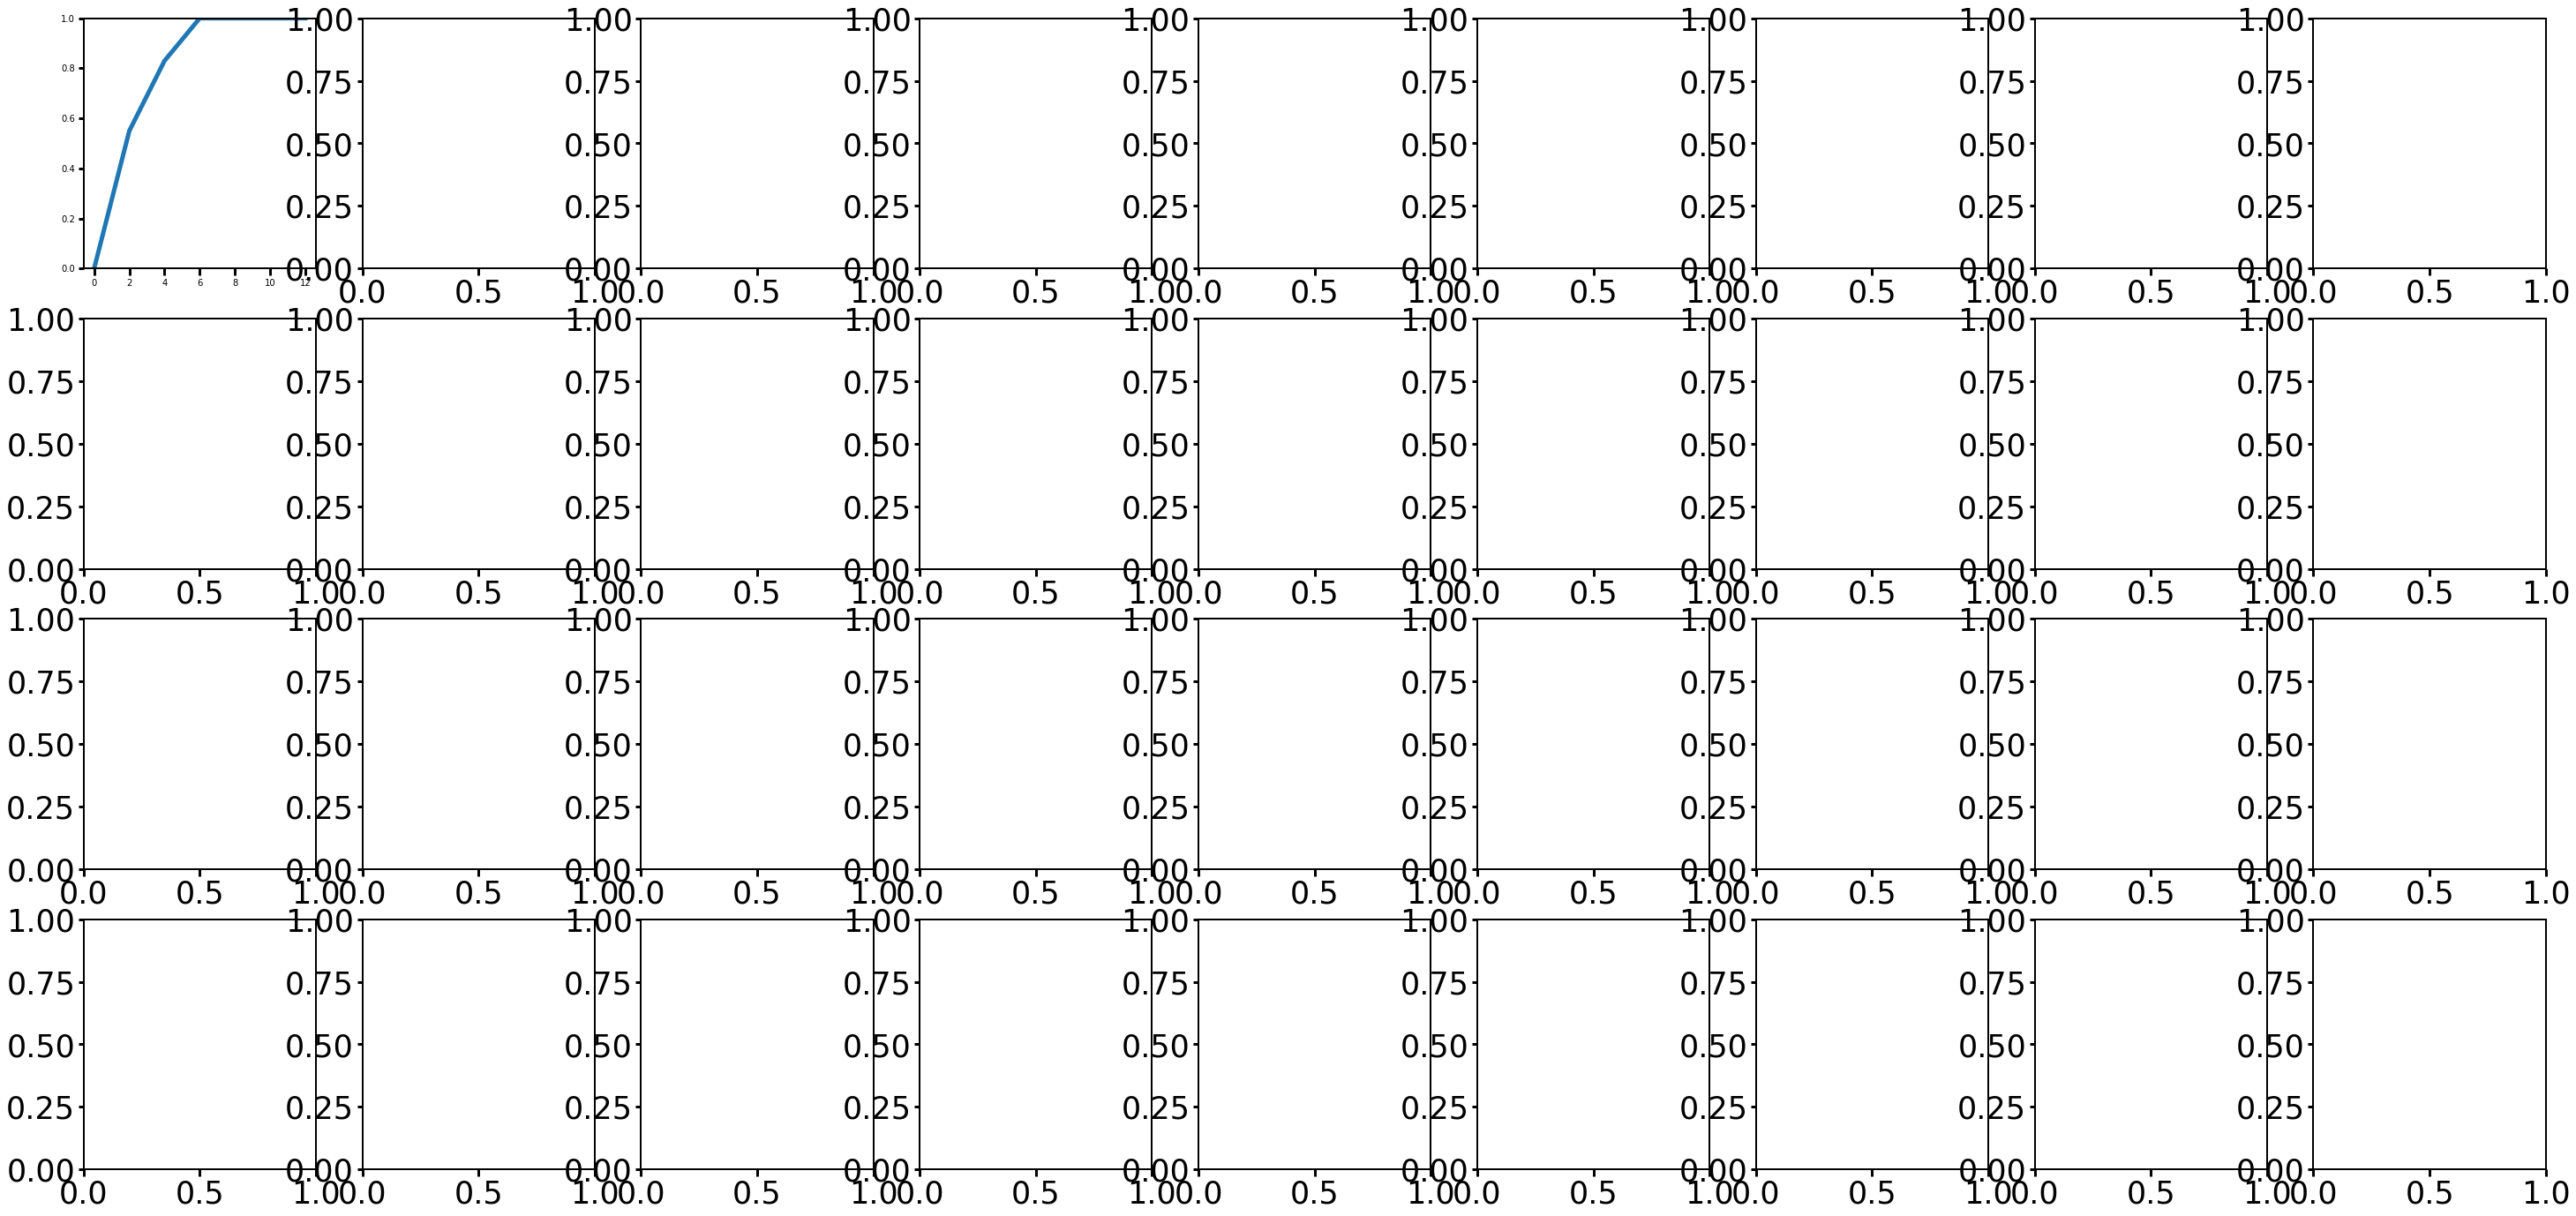

In [6]:
plot_baseline_comparison(recs, n_type="EXC", signal= signal, approx="mean", stim_ampl="threshold", only_mlr_signif=False, ylim=[-1,200])

In this figure the baseline before the detected stimulus (1st boxplot) is compared to the baseline before the undetected stimulus for all the different recording. The amplitude of the stimulus that is chosen for each comparison is manual defined from the observation of the psychometric curve plotted above the boxplots, it should have enough detected and undetected trials to be able to do the comparison. WT mice are on the first line and KO mice are on the second line.
We can observe that the baseline is significantly higher for 4 of 6 of the KO mice and 5 out of 7 WT mice. It seems that could be an explanation of the failed detection for both genotype.

### Stimulation above mean WT threshold amplitudes

In [ ]:
plot_baseline_comparison(recs, n_type="EXC", signal= signal, approx="mean", stim_ampl=above_wt_threshold, only_mlr_signif=False, ylim=[-1,100],responsive_neur=False)

In [ ]:
plot_baseline_comparison(recs, n_type="EXC", signal= signal, approx="mean", stim_ampl=above_wt_threshold, only_mlr_signif=False, ylim=[-1,100],responsive_neur=True)

### Stimulation below mean WT threhsold 

In [ ]:
plot_baseline_comparison(recs, n_type="EXC", signal= signal, approx="mean", stim_ampl=below_wt_threshold, only_mlr_signif=False, ylim=[-1,100])

## Std of baseline

### Stimulation at threshold amplitude

In [ ]:
plot_baseline_comparison(recs, n_type="EXC", signal= signal, approx="std", stim_ampl="threshold", only_mlr_signif=False, ylim=[0,3])

The comparisons of the standard deviation of the baseline for KO group are still the same but for the WT group only 3 out of 7 are still significant

### Stimulation above mean WT threshold amplitude

In [ ]:
plot_baseline_comparison(recs, n_type="EXC",signal= signal, approx="std", stim_ampl=above_wt_threshold, only_mlr_signif=False, ylim=[0, 3])

## MLR significant and inhibitory neurons

The next step is to compare only the neurons that were found significant with the MLR analysis, maybe the neurons silent or non-responding parasite the comparison of the baseline. We test here for all MLR neurons independently of their mlr labels

In [ ]:
plot_baseline_comparison(recs, n_type="EXC", approx="mean", signal= signal, stim_ampl=above_wt_threshold, only_mlr_signif=True, ylim=[-1,2])

The global trend seems to be the same in KO mice but lot less significant animals. The result is opposite of what we hypothesised before. It seems even that in WT group the dynamic is opposite, the firing neurons have lower baseline in non detected stimulus. Similar analysis should be made with a discrimination of the  clusters of neurons 



Testing with all inhibitory cells

In [ ]:
plot_baseline_comparison(recs, n_type="INH",signal= signal, approx="mean", stim_ampl="threshold", only_mlr_signif=False, ylim=[-1,2])

# Activation vs. inhibition of the neuron for all stimuli in the same animal

___

Comparison of baseline for all exc neurons in between when it is activated and when it is inhibited

In [ ]:
def plot_diff_neuron_act(recs, n_type="EXC", first_group=1, second_group=-1, y_lim=[0,2], responsive_neur=False):
    label_dict = {0: "non_active", 1: "activated", -1: "inhibited"}
    y, i = 0, 0
    fig, ax = plt.subplots(4, 9, figsize=(50, 20))
  
    for rec  in recs.values():
        # if rec.filename == 4456:
        #     continue
        if signal == "zscore"
            trace = rec.zscore_exc if n_type == "EXC" else rec.zscore_inh
        elif signal =="df_f":
            trace = rec.df_f_exc if n_type == "EXC" else rec.df_f_inh
        if responsive_neur:
            ids_resp, ids_inh = idx_resp_neur(rec, n_type=n_type)
            if len(ids_resp)<3:
                continue
            trace = trace[ids_resp] if n_type == "EXC" else trace[ids_resp]
        #  get all the bsl before stim of the corresponding amp stim
        act_bsl = []
        nact_bsl = []
        for idx, n_df in enumerate(trace):
            resp_n = np.array(rec.matrices[n_type]["Responsivity"][idx])
            act_bsl_n = n_df[np.linspace(rec.stim_time[resp_n == first_group ] - int(bsl_window * rec.sf) - sanity_frames, rec.stim_time[resp_n == first_group ]-sanity_frames, int(bsl_window * rec.sf) , dtype=int)]
            nact_bsl_n = n_df[np.linspace(rec.stim_time[resp_n == second_group] - int(bsl_window * rec.sf) -sanity_frames, rec.stim_time[resp_n == second_group]-sanity_frames, int(bsl_window * rec.sf) , dtype=int)]
            if act_bsl_n.shape[1]!=0 and nact_bsl_n.shape[1]!=0 : 
                act_bsl.append(np.mean(np.mean(act_bsl_n,axis=0)))
                nact_bsl.append(np.mean(np.mean(nact_bsl_n,axis=0)))
        if rec.genotype == "WT":
            pbh.psycho_like_plot(rec, roi_info, ax[0, i])
            ppt.paired_boxplot(ax[1, i], np.array(act_bsl), np.array(nact_bsl), "mean baseline","",colors=[ppt.wt_color, ppt.light_wt_color],ylim=[-1, 6], allow_stats_skip=True)
            ax[1, i].set_ylim(y_lim)
            i += 1
        else:
            pbh.psycho_like_plot(rec, roi_info, ax[2, y])
            ppt.paired_boxplot(ax[3, y], np.array(act_bsl), np.array(nact_bsl), "mean baseline","",ylim=[-1,6], allow_stats_skip=True)
            ax[3, y].set_ylim(y_lim)
            y += 1
                
    fig.suptitle(f"Mean baseline comparison {label_dict[first_group]} vs {label_dict[second_group]} for all exc neurons", y=1.05, fontsize=26)
    fig.tight_layout()

## Activated (1)  vs Inhibited (-1)

In [ ]:
plot_diff_neuron_act(recs, n_type="EXC", first_group=1, second_group=-1, y_lim=[0,6])

## Baseline (0)  vs Inhibited (-1)

In [ ]:
plot_diff_neuron_act(recs, n_type="EXC", first_group=0, second_group=-1,y_lim=[-1,2])

## Baseline (0)  vs Activated (1)


In [ ]:
plot_diff_neuron_act(recs, n_type="EXC", first_group=0, second_group=1,y_lim=[-1,6], responsive_neur=False)

 Check if there is differences of cross correlation in the baseline activity before the stim 

(49, 15, 6)
(6,)
(103, 15, 13)
(13,)
(101, 15, 17)
(17,)
(58, 15, 24)
(24,)
(38, 15, 11)
(11,)
(127, 15, 18)
(18,)
(84, 15, 18)
(18,)
(91, 15, 3)
(3,)
(103, 15, 10)
(10,)
(55, 15, 12)
(12,)
(42, 15, 9)
(9,)
(66, 15, 22)
(22,)
(125, 15, 18)
(18,)
(51, 15, 5)
(5,)
(62, 15, 29)
(29,)
(76, 15, 15)
(15,)
(98, 15, 22)
(22,)
(131, 15, 28)
(28,)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9263795614242554, pvalue=0.4476530849933624)
ShapiroResult(statistic=0.9678657054901123, pvalue=0.8758851289749146)
Ttest_relResult(statistic=-0.6512766384642616, pvalue=0.5331253509734966)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.7803060412406921, pvalue=0.05545487254858017)
ShapiroResult(statistic=0.8639371991157532, pvalue=0.2427321821451187)
Ttest_relResult(statistic=-2.8312739385879215, pvalue=0.04728391767008413)
(49, 15, 0)
(0,)
(103, 15, 5)
(5,)
(101, 15, 1)
(1,)


/datas/Théo/Spikesorting/venv/Spikesorting2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/datas/Théo/Spikesorting/venv/Spikesorting2/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/datas/Théo/Spikesorting/venv/Spikesorting2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/datas/Théo/Spikesorting/venv/Spikesorting2/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


(58, 15, 5)
(5,)
(38, 15, 1)
(1,)
(127, 15, 1)
(1,)
(84, 15, 24)
(24,)
(91, 15, 1)
(1,)
(103, 15, 6)
(6,)
(55, 15, 1)
(1,)
(42, 15, 3)
(3,)
(66, 15, 13)
(13,)
(125, 15, 2)
(2,)
(51, 15, 3)
(3,)
(62, 15, 36)
(36,)
(76, 15, 7)
(7,)
(98, 15, 24)
(24,)
(131, 15, 29)
(29,)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9198175072669983, pvalue=0.4283845126628876)
ShapiroResult(statistic=0.8511910438537598, pvalue=0.0979505255818367)
Ttest_relResult(statistic=-1.3449157124725046, pvalue=0.22059384603583282)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.8948096036911011, pvalue=0.3007020950317383)
ShapiroResult(statistic=0.8559529185295105, pvalue=0.13921408355236053)
Ttest_relResult(statistic=-1.4999546533032904, pvalue=0.18429212353665256)
(15, 15, 6)
(6,)
(22, 15, 13)
(13,)
(19, 15, 17)
(17,)
(13, 15, 24)
(24,)
(9, 15, 11)
(11,)
(14, 15, 18)
(18,)
(18, 15, 18)
(18,)
(29, 15, 3)
(3,)
(19, 15, 10)
(10,)
(18, 15, 12)
(12,)


/datas/Théo/Spikesorting/venv/Spikesorting2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/datas/Théo/Spikesorting/venv/Spikesorting2/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/datas/Théo/Spikesorting/venv/Spikesorting2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/datas/Théo/Spikesorting/venv/Spikesorting2/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


(5, 15, 9)
(9,)
(20, 15, 22)
(22,)
(20, 15, 18)
(18,)
(15, 15, 5)
(5,)
(8, 15, 29)
(29,)
(10, 15, 15)
(15,)
(14, 15, 22)
(22,)
(12, 15, 28)
(28,)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.8946812152862549, pvalue=0.22275809943675995)
ShapiroResult(statistic=0.9273553490638733, pvalue=0.45657867193222046)
Ttest_relResult(statistic=0.025427199520777655, pvalue=0.9803370373265071)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9226762056350708, pvalue=0.5473495125770569)
ShapiroResult(statistic=0.9099977612495422, pvalue=0.46757692098617554)
Ttest_relResult(statistic=0.49060914723135907, pvalue=0.6493992460892728)
(15, 15, 0)
(0,)
(22, 15, 5)
(5,)
(19, 15, 1)
(1,)
(13, 15, 5)
(5,)
(9, 15, 1)
(1,)
(14, 15, 1)
(1,)
(18, 15, 24)
(24,)
(29, 15, 1)
(1,)
(19, 15, 6)
(6,)
(18, 15, 1)
(1,)
(5, 15, 3)
(3,)
(20, 15, 13)
(13,)
(20, 15, 2)
(2,)
(15, 15, 3)
(3,)
(8, 15, 36)
(36,)
(10, 15, 7)
(7,)
(14, 15, 24)
(24,)
(12, 15, 29)
(29,)
Boxplot plotting.
--- mea

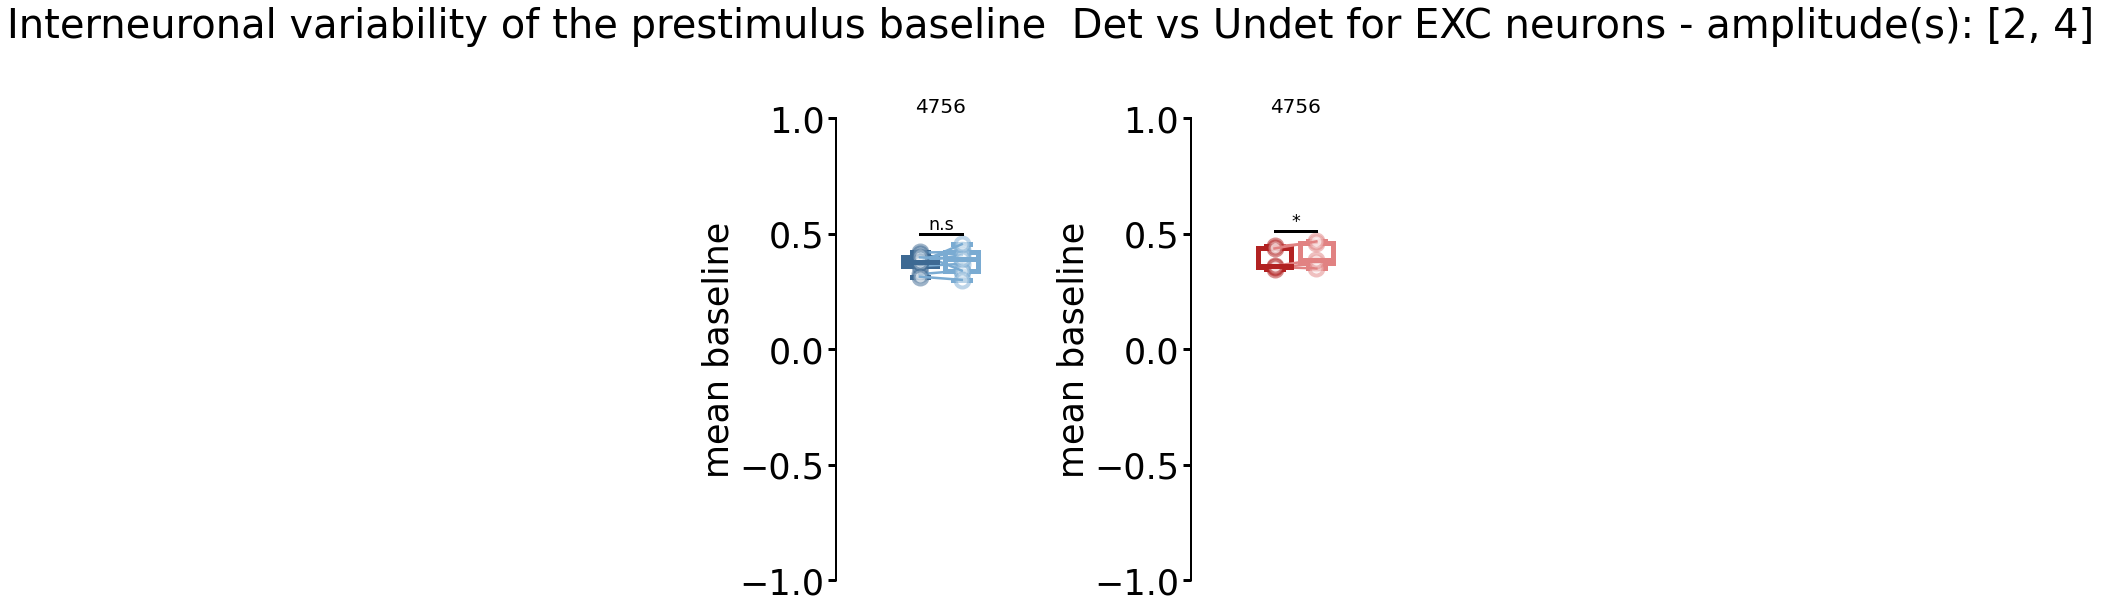

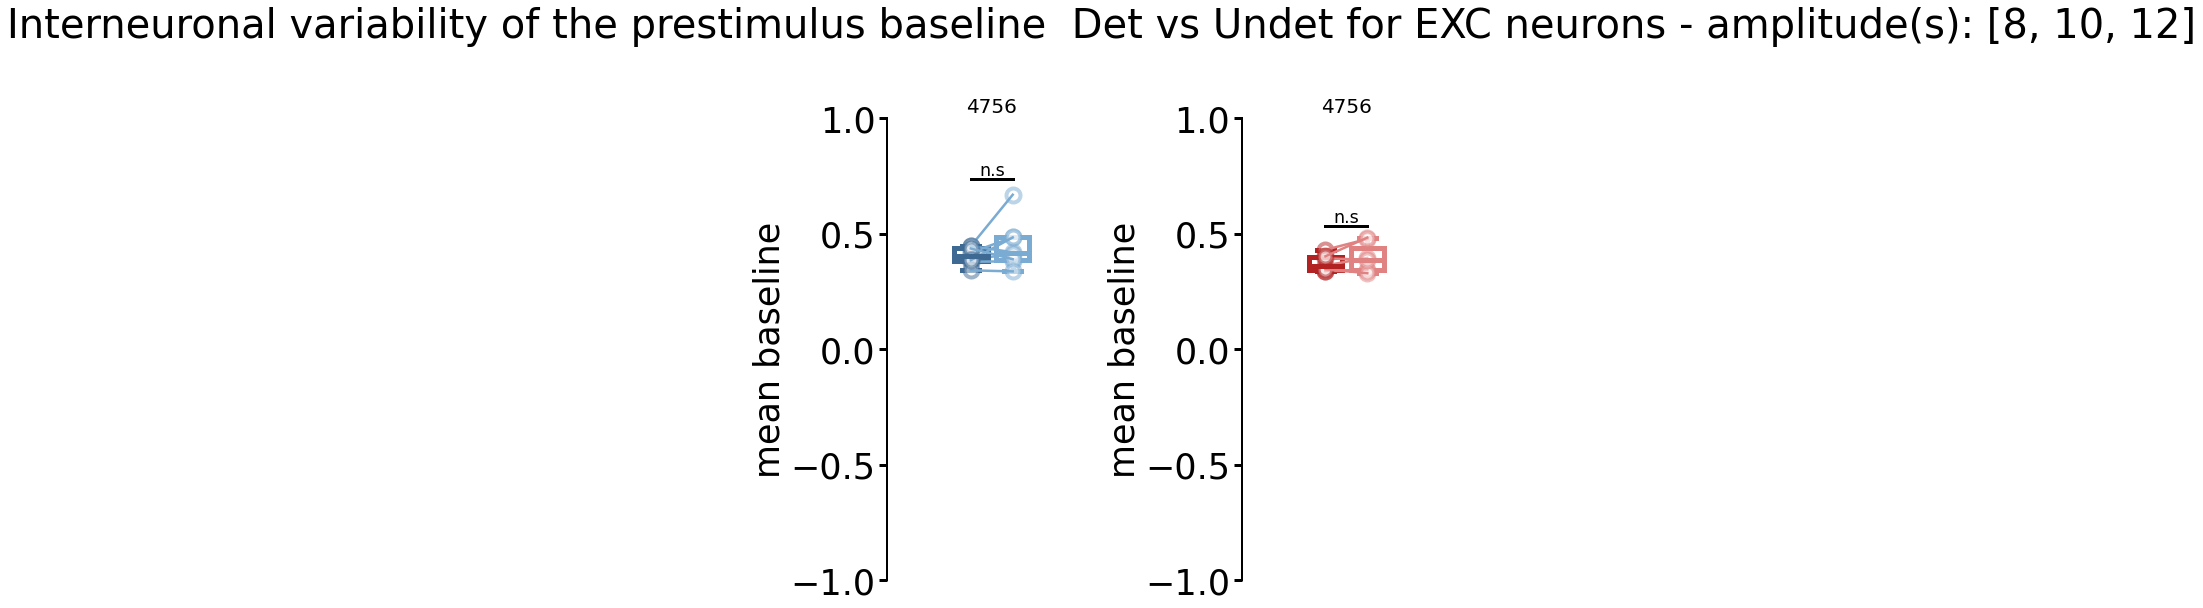

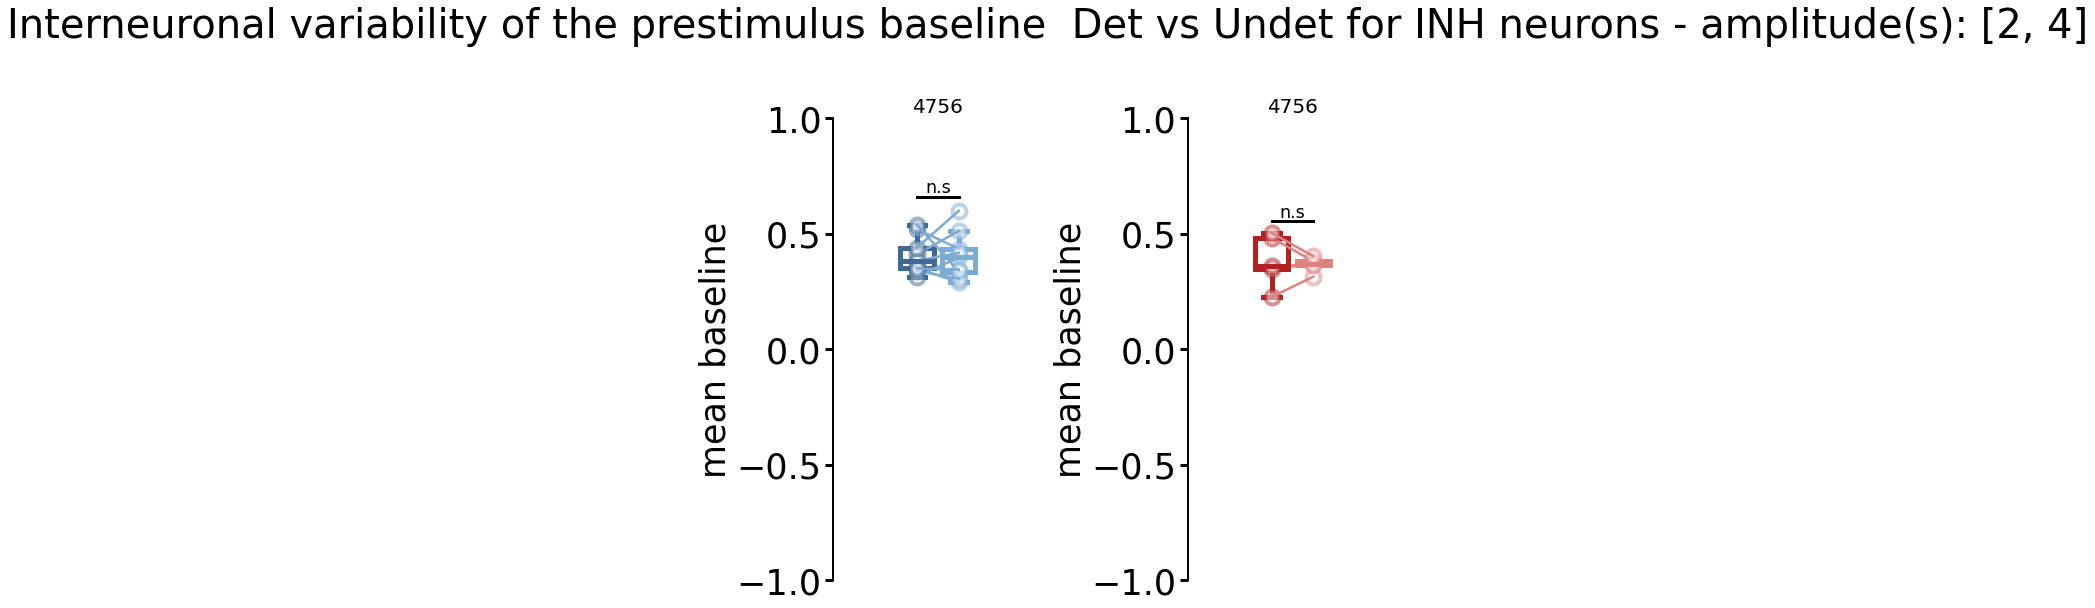

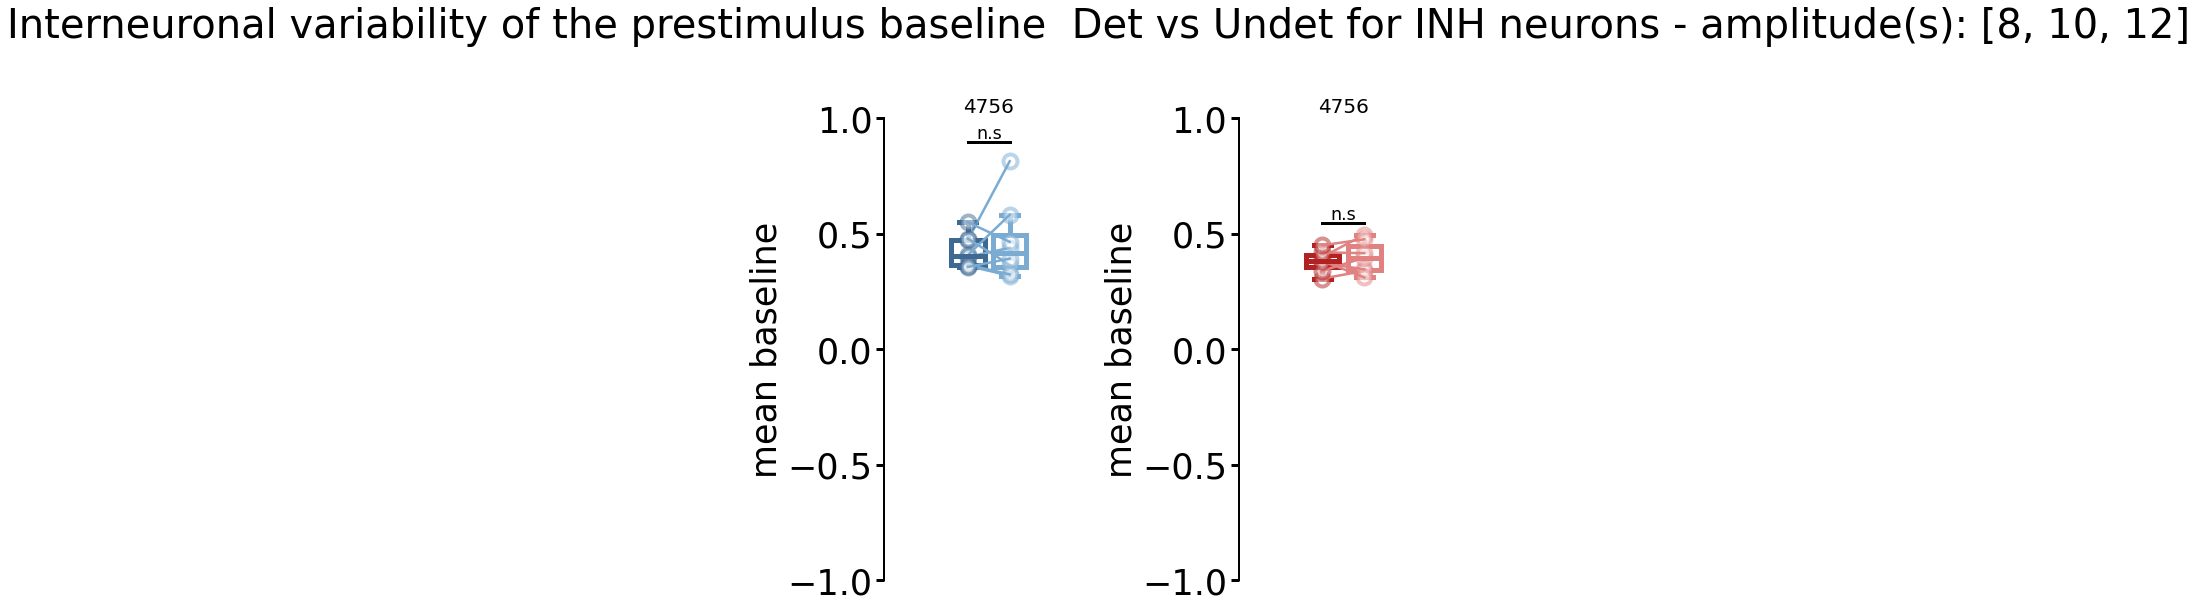

In [28]:
signal = "dff_f"
def plot_baseline_correlation(recs, n_type="EXC",signal="zscore", approx="mean", stim_ampl="threshold", only_mlr_signif=False, ylim=[], responsive_neur=False):
    bsl_window = 0.5
    wt_det, wt_undet, ko_det, ko_undet= [],[],[],[]
    for rec in recs.values():
            if signal == "zscore":
                trace = rec.zscore_exc if n_type == "EXC" else rec.zscore_inh
            elif signal == "dff_f":
                trace = rec.df_f_exc if n_type == "EXC" else rec.df_f_inh
            if only_mlr_signif:
                mlr_model, model_name = mlr_m.precise_stim_model(rec)
                rec.mlr(mlr_model, model_name)
                trace = trace[rec.mlr_labels_exc["indices_r2"]] if n_type == "EXC" else trace[rec.mlr_labels_inh["indices_r2"]]
            if responsive_neur:
                ids_resp, ids_inh = idx_resp_neur(rec, n_type=n_type)
                if len(ids_resp)<3:
                    continue
                trace = trace[ids_resp] if n_type == "EXC" else trace[ids_resp]
            
            #  get all the bsl before stim of the corresponding amp stim
            det_amp_filter = np.logical_and(rec.detected_stim, rec.stim_ampl_filter(stim_ampl=stim_ampl, include_no_go=False))
            stims_det = rec.stim_time[det_amp_filter]-sanity_frames
            bsl_det = trace[:, np.linspace(stims_det - int(bsl_window * rec.sf), stims_det, int(bsl_window * rec.sf), dtype=int)]
            # r_bsl_d = bsl_det.reshape(len(trace), len(stims_det) * int(bsl_window * rec.sf))
            
            undet_amp_filter = np.logical_and(np.invert(rec.detected_stim), rec.stim_ampl_filter(stim_ampl=stim_ampl, include_no_go=False))
            stims_undet = rec.stim_time[undet_amp_filter]-sanity_frames
            bsl_undet = trace[:, np.linspace(stims_undet - int(bsl_window * rec.sf), stims_undet, int(bsl_window * rec.sf), dtype=int)]
            print(bsl_undet.shape)
            # r_bsl_u = bsl_undet.reshape(len(trace), len(stims_undet) * int(bsl_window * rec.sf))
            print(np.std(np.mean(bsl_undet, axis=1), axis=0).shape)
            if approx == "mean":
                det_bsl = np.mean(np.std(np.median(bsl_det, axis=1), axis=0))
                undet_bsl = np.mean(np.std(np.median(bsl_undet, axis=1),axis=0))
            elif approx == "std":
                det_bsl = np.mean(np.std(np.std(bsl_det, axis=1),axis=0))
                undet_bsl = np.mean(np.std(np.std(bsl_undet, axis=1),axis=0))
            if np.isnan(undet_bsl):
                continue
            if rec.genotype == "WT":
                wt_det.append(det_bsl)
                wt_undet.append(undet_bsl)
            elif rec.genotype== "KO-Hypo":
                ko_det.append(det_bsl)
                ko_undet.append(undet_bsl)


    fig, ax = plt.subplots(1, 2, figsize=(10, 8))
    wt_nan =np.logical_and(~np.isnan(wt_det),~np.isnan(wt_undet))
    ko_nan =np.logical_and(~np.isnan(ko_det),~np.isnan(ko_undet))
    ppt.paired_boxplot(ax[0],np.array(wt_det)[wt_nan], np.array(wt_undet)[wt_nan], f"{approx} baseline", rec.filename,colors=[ppt.wt_color, ppt.wt_light_color], ylim=ylim, allow_stats_skip=True)
    ppt.paired_boxplot(ax[1], np.array(ko_det)[ko_nan], np.array(ko_undet)[ko_nan], f"{approx} baseline", rec.filename,colors=[ppt.hypo_color, ppt.hypo_light_color], ylim=ylim)

    fig.suptitle(f"Interneuronal variability of the prestimulus baseline  Det vs Undet for {n_type} neurons - amplitude(s): {stim_ampl}", y=1.05,fontsize=40)
    fig.tight_layout()
signal ="zscore"
plot_baseline_correlation(recs, n_type="EXC",signal= signal, approx="mean", stim_ampl=below_wt_threshold, only_mlr_signif=False, ylim=[-1,1], responsive_neur=False)
plot_baseline_correlation(recs, n_type="EXC",signal= signal, approx="mean", stim_ampl=above_wt_threshold, only_mlr_signif=False, ylim=[-1,1], responsive_neur=False)
plot_baseline_correlation(recs, n_type="INH",signal= signal, approx="mean", stim_ampl=below_wt_threshold, only_mlr_signif=False, ylim=[-1,1], responsive_neur=False)
plot_baseline_correlation(recs, n_type="INH",signal= signal, approx="mean", stim_ampl=above_wt_threshold, only_mlr_signif=False, ylim=[-1,1], responsive_neur=False)

# SNR prestimulus/ stimulus 

5889
7.851259
6601
1.1322231
4939
-3.0504856
5893
45.745785
5886
-10.447092
4456
-2.9413557
5873
-5.7190747
5881
2.20181
5879
-0.8100777
4754
-1.9326683
5890
-2.050366
4745
2.1819823
6606
-69.609116
5896
-1.3364189
4445
-2.023221459039948
4756
-1.6984907
Boxplot plotting.
--- SNR baseline ---
ShapiroResult(statistic=0.601919412612915, pvalue=0.00010077136539621279)
ShapiroResult(statistic=0.7983456254005432, pvalue=0.07855194061994553)
MannwhitneyuResult(statistic=15.0, pvalue=0.36363636363636365)


/datas/Théo/Projects/Percephone/percephone/plts/stats.py:112: UserWarning: The ylim you have set don't cover the data range.
  warnings.warn("The ylim you have set don't cover the data range.")


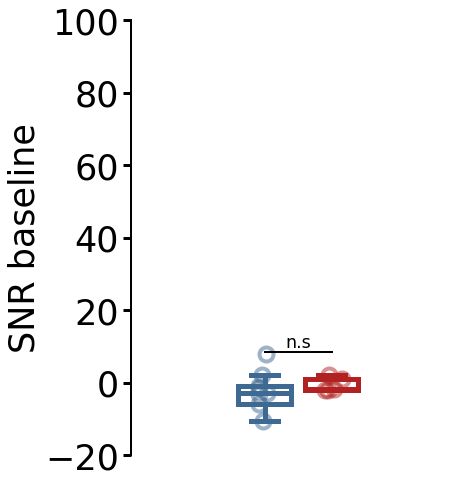

In [208]:
from percephone.analysis.utils import corrected_prestim_windows
sanity_frame = 5
bsl_window = 0.5 #  (s)
wt,ko = [],[]
wt_threhsold = 7
for rec in recs.values():
    stim_cor = corrected_prestim_windows(rec)[rec.stim_ampl>wt_threhsold ]
    snrs = []
    id_act, id_inhibited = idx_resp_neur(rec)
    for id, neur in enumerate(rec.df_f_exc[id_act]):
        # neur[neur<0]=0
        neur_bsls =  np.mean(neur[np.linspace(stim_cor -int(bsl_window*rec.sf) - sanity_frames,stim_cor-sanity_frames,int(bsl_window*rec.sf),dtype=int)],axis=0)
        neur_resp = np.std(neur[np.linspace(stim_cor , stim_cor+rec.stim_durations[rec.stim_ampl>7], int(bsl_window*rec.sf),dtype=int)],axis=0)
        snrs.append(np.divide(neur_resp,neur_bsls))
    if np.isnan(snrs).all():
        continue
    print(rec.filename)
    print(np.nanmean(snrs))
    if rec.genotype == "WT":
        wt.append(np.nanmean(snrs))
    elif rec.genotype== "KO-Hypo":
        ko.append(np.nanmean(snrs))
fig, ax = plt.subplots(1,1,figsize=(6,8))
ppt.boxplot(ax, wt, ko, f"SNR baseline", ylim=[-20,100])

# Interquartile of df_f mean correlation with detection.

In [205]:
signal = "dff_f"
window = 0.5
def SNR_matrice(n_type='EXC', by_group=True, type_snr="fr_neurons"):
    fig,ax = plt.subplots(1,1,figsize=(12,12))
    ax.set_title(type_snr)
    snr_amp_wt, snr_amp_ko = [],[]
    for rec in recs.values():
        print(rec.filename)
        if rec.filename ==4456:
            continue
        if signal == "zscore":
            trace = rec.zscore_exc if n_type == "EXC" else rec.zscore_inh
        elif signal == "dff_f":
            trace = rec.df_f_exc if n_type == "EXC" else rec.df_f_inh
        noises, fr_neurons=[], []
        amps = np.linspace(2,12,6)
        for amp in amps:
            stims = corrected_prestim_windows(rec)[(rec.stim_ampl==amp) ] #
            prestim_pop_var = trace[:,np.linspace(stims - int(window * rec.sf),stims, int(window*rec.sf)+1 ,dtype=int)]
            nb_neurons = np.mean(np.count_nonzero(rec.matrices["EXC"]["Responsivity"][:,(rec.stim_ampl==amp) ],axis=0))
            noise = np.mean(np.var(np.median(prestim_pop_var,axis=1),axis=0))
            noises.append(noise)
            fr_neurons.append(nb_neurons/rec.zscore_exc.shape[0])
        if type_snr == "fr_neurons":
            ax.set_ylim([0,0.01])
            snr = np.array(fr_neurons)/noises
        if type_snr == "stim_amp":
            ax.set_ylim([0,1])
            snr = amps/noises
            snr_normalized =  ((snr - min(snr)) /max(snr))*100
        if rec.genotype == "WT":
            snr_amp_wt.append(snr)
            if not by_group:
                ax.plot(amps, snr, color=ppt.wt_color, lw=3)
        elif rec.genotype== "KO-Hypo":
            snr_amp_ko.append(snr)
            if not by_group:
                ax.plot(amps, snr, color=ppt.ko_color, lw=3)
        if not by_group:
            y = (snr)[-1]
            ax.annotate(rec.filename, xy=(1,y), xytext=(6,0),
                    xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                    size=14, va="center")
    if by_group:
        ax.plot(amps, np.mean(snr_amp_wt,axis=0), color=ppt.wt_color, lw=4, linestyle="--")
        ax.plot(amps, np.mean(snr_amp_ko,axis=0), color=ppt.ko_color, lw=4)


5889
6601
4939
5893
5886
4456
6611
5873
5881
5879
4754
5890
4745
6606
6609
5896
4445
4756
5889
6601
4939
5893
5886
4456
6611
5873
5881
5879
4754
5890
4745
6606
6609
5896
4445
4756
5889
6601
4939
5893
5886
4456
6611
5873
5881
5879
4754
5890
4745
6606
6609
5896
4445
4756
5889
6601
4939
5893
5886
4456
6611
5873
5881
5879
4754
5890
4745
6606
6609
5896
4445
4756


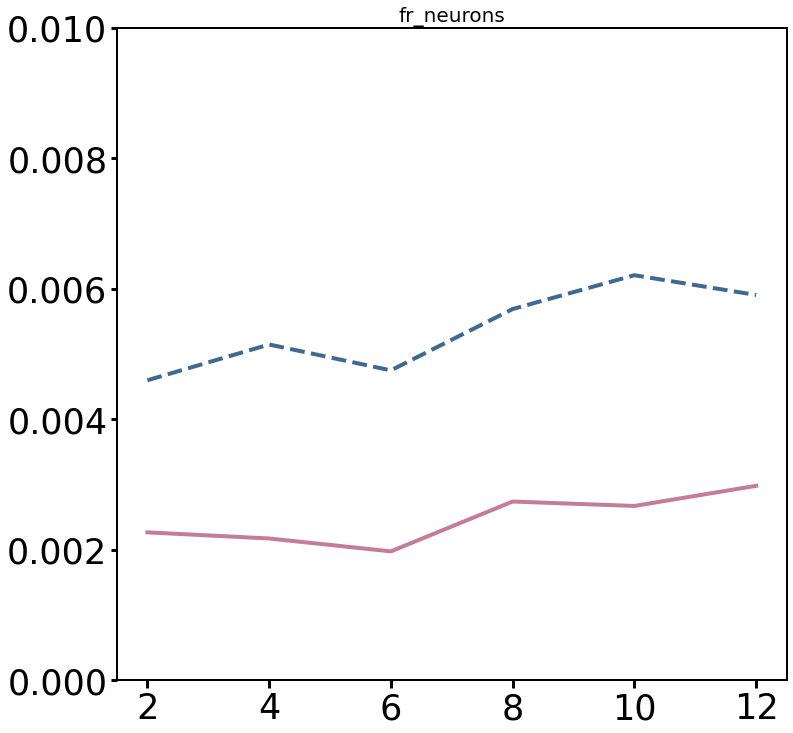

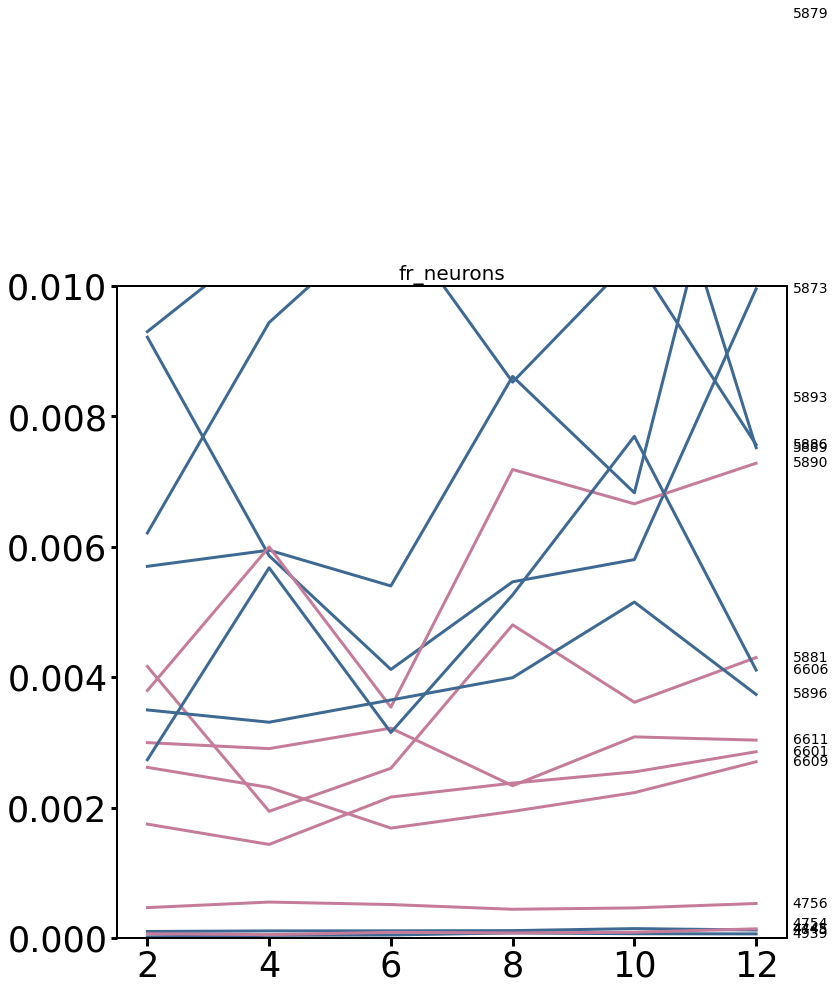

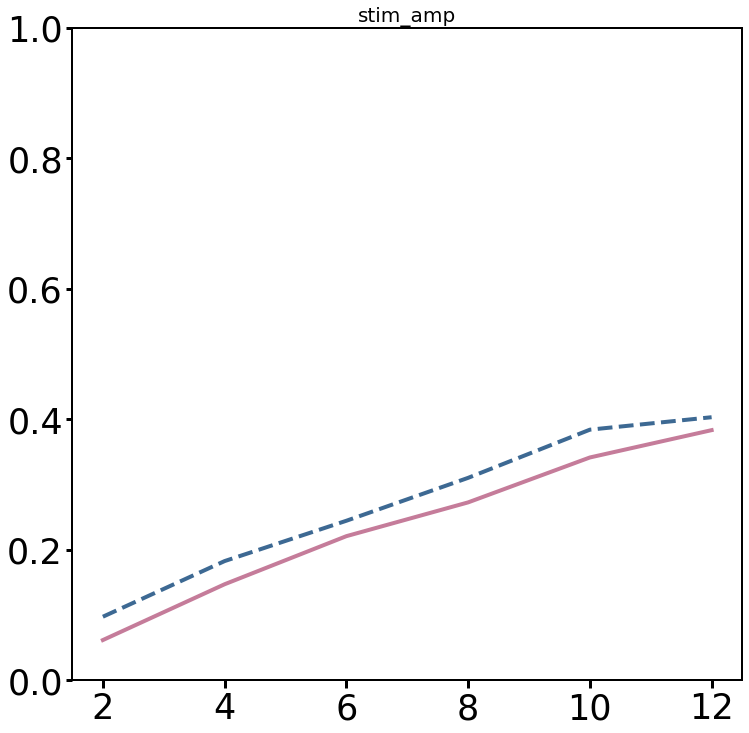

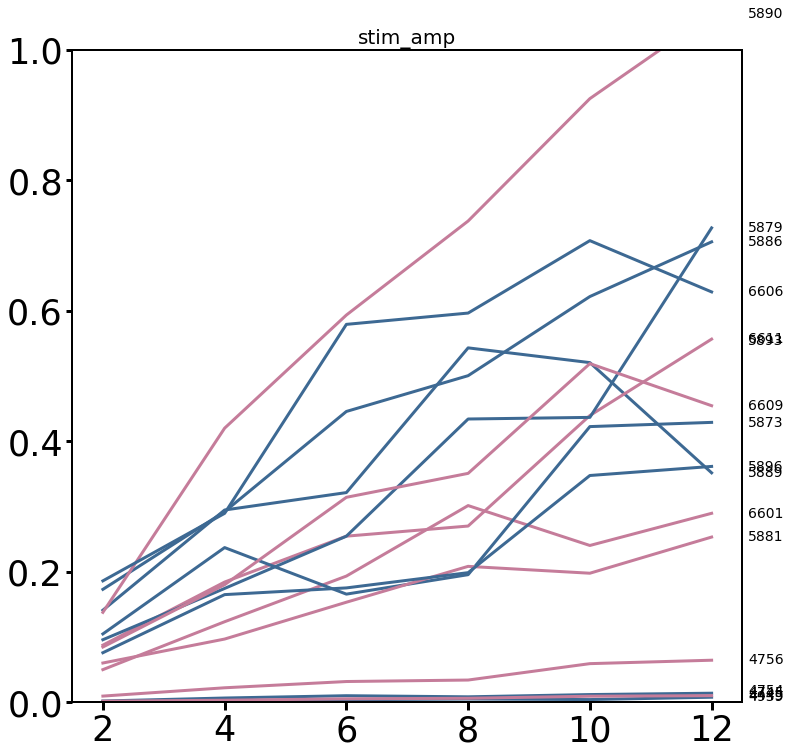

In [206]:
SNR_matrice(n_type='EXC',type_snr="fr_neurons")
SNR_matrice(n_type='EXC',type_snr="fr_neurons", by_group=False)
SNR_matrice(n_type='EXC',type_snr="stim_amp")
SNR_matrice(n_type='EXC',type_snr="stim_amp", by_group=False)

5889
(0.08661086132675302, 0.680589663234477)
6601
(0.23166408244393105, 0.2180233120575282)
4939
(2.9475601704326282e-05, 0.9998988262683258)
5893
5886
(0.09621675076814662, 0.5601099016825042)
4456
6611
(0.24499084334711785, 0.16939622055799045)
5873
(-0.066432929869599, 0.8461239704532204)
5881
(0.14085884717713798, 0.5425115122339719)
5879
(0.033886626202152895, 0.8640784378471068)
4754
5890
(0.15871369113494072, 0.4021985698933325)
4745
(-0.5203139529676347, 0.01304910610808628)
6606
(0.31270374961764447, 0.17947812798375593)
6609
(0.4445239607933562, 0.0035936712714063138)
5896
(-0.0012352757622094146, 0.9947379275738736)
4445
(0.127996070563659, 0.4374357851741808)
4756
(0.07510074148525331, 0.658658859155594)


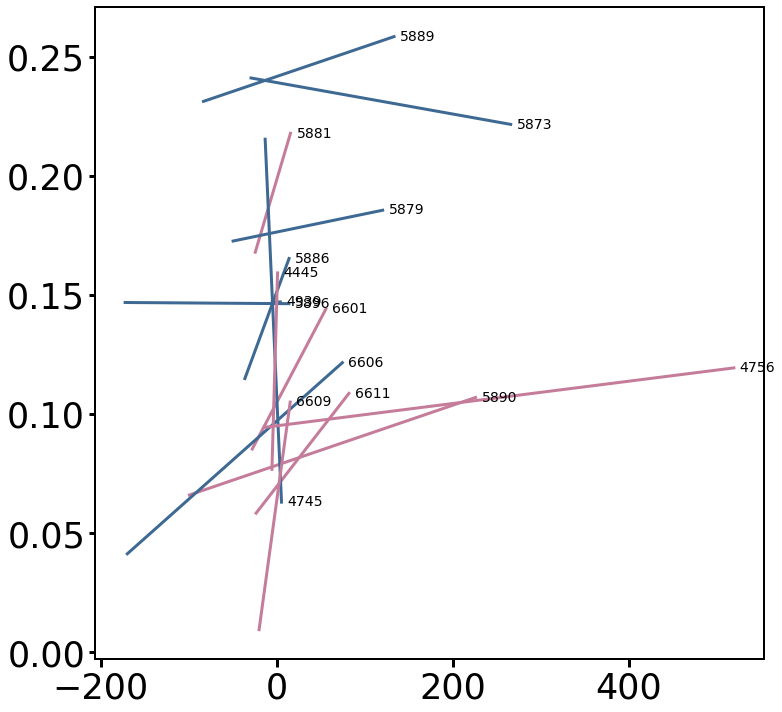

In [248]:
signal = "dff_f"
window = 0.5
def cor_snr_perc_magnitude(n_type='EXC', by_group=True, linear=True):
    fig,ax = plt.subplots(1,1,figsize=(12,12))
    snr_amp_wt, snr_amp_ko = [],[]
    for rec in recs.values():
        print(rec.filename)
        if rec.filename ==4456:
            continue
        if rec.genotype == "KO":
            continue
        if signal == "zscore":
            trace = rec.zscore_exc if n_type == "EXC" else rec.zscore_inh
        elif signal == "dff_f":
            trace = rec.df_f_exc if n_type == "EXC" else rec.df_f_inh
        stim_filter = [rec.stim_ampl>7][0]
        stims = corrected_prestim_windows(rec)[stim_filter]
        prestim_pop_var = trace[:,np.linspace(stims - int(window * rec.sf),stims, int(window*rec.sf)+1 ,dtype=int)]
        nb_neurons =np.count_nonzero(rec.matrices["EXC"]["Responsivity"][:,stim_filter],axis=0)
        noise =np.mean(np.median(prestim_pop_var,axis=1),axis=0)
        fr_neurons=nb_neurons/rec.zscore_exc.shape[0]
        amps = rec.stim_ampl[stim_filter]
        snr = amps/noise
        sort = np.argsort(snr)
        print(ss.pearsonr(snr[sort],fr_neurons[sort]))
        
        if rec.genotype == "WT":
            snr_amp_wt.append(snr)
            fit_color = ppt.wt_color
            if not by_group and not linear:
                ax.plot(snr[sort], fr_neurons[sort], color=ppt.wt_color, lw=3)
        elif rec.genotype== "KO-Hypo":
            snr_amp_ko.append(snr)
            fit_color = ppt.ko_color
            if not by_group and not linear:
                ax.plot(snr[sort], fr_neurons[sort], color=ppt.ko_color, lw=3)
        if linear:
            reg = LinearRegression().fit(np.array(snr[sort]).reshape(-1, 1),fr_neurons[sort])
            y_pred = reg.predict(np.linspace(min(snr[sort]),max(snr[sort]),30).reshape(-1, 1))
            x=np.linspace(min(snr[sort]),max(snr[sort]),30)
            ax.plot(x,y_pred,color=fit_color,lw=3)
        if not by_group and linear:
            y = (y_pred)[-1]
            x= x[-1]
            ax.annotate(rec.filename, xy=(x,y), xytext=(6,0),
                    textcoords="offset points",
                    size=14, va="center")

cor_snr_perc_magnitude(n_type='EXC', by_group=False, linear = True)

5889
(0.08661086132675302, 0.680589663234477)
6601
(0.23166408244393105, 0.2180233120575282)
4939
(2.9475601704326282e-05, 0.9998988262683258)
5893
5886
(0.09621675076814662, 0.5601099016825042)
4456
6611
(0.24499084334711785, 0.16939622055799045)
5873
(-0.066432929869599, 0.8461239704532204)
5881
(0.14085884717713798, 0.5425115122339719)
5879
(0.033886626202152895, 0.8640784378471068)
4754
5890
(0.15871369113494072, 0.4021985698933325)
4745
(-0.5203139529676347, 0.01304910610808628)
6606
(0.31270374961764447, 0.17947812798375593)
6609
(0.4445239607933562, 0.0035936712714063138)
5896
(-0.0012352757622094146, 0.9947379275738736)
4445
(0.127996070563659, 0.4374357851741808)
4756
(0.07510074148525331, 0.658658859155594)


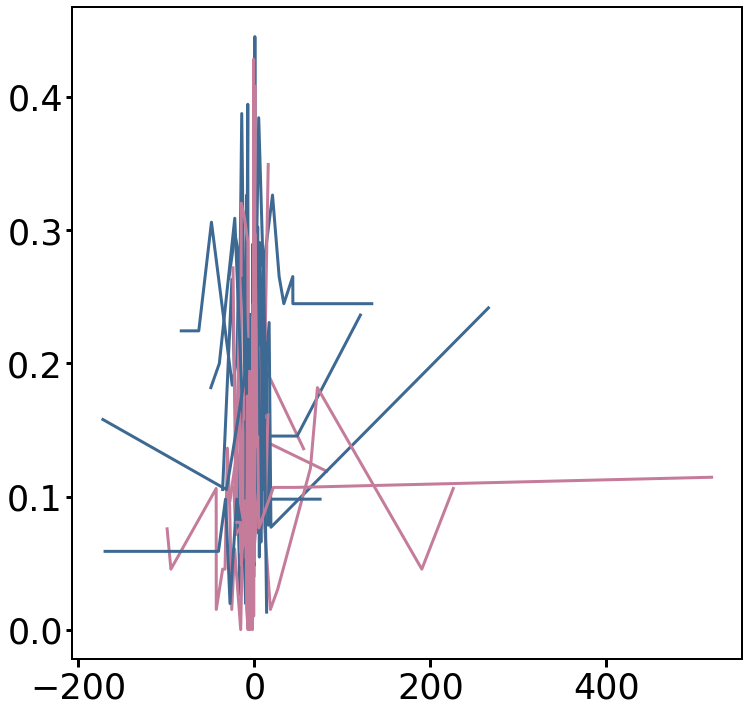

In [249]:
cor_snr_perc_magnitude(n_type='EXC', by_group=False, linear=False)